# HuBMAP PyTorch Train & Infer


# Installs

In [1]:
# !pip install monai staintools spams --no-index --find-links=../input/hubmap-downloads

In [2]:
# !pip install pytorch-lightning 

In [3]:
# !pip install seaborn

In [4]:
# !pip install tifffile

In [5]:
# !pip install monai --force-reinstall

In [6]:
# !pip install ipywidgets widgetsnbextension

In [7]:
# !pip install torch --force-reinstall

In [8]:
# !pip install albumentations

In [9]:
# !pip install opencv-python-headless==4.5.2.52

# Imports

In [10]:
import tifffile
from glob import glob
import cv2 as cv
import os

In [11]:
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Dict
from typing import Optional
from typing import Tuple

import numpy as np
import pandas as pd


import seaborn as sns
import staintools
import tifffile
import random

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from monai.data import CSVDataset
from monai.data import DataLoader
from monai.data import ImageReader
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import albumentations as A
import albumentations.pytorch

In [13]:
from IPython.display import clear_output

# Paths & Settings

In [14]:
# for fname in tqdm(glob('./../data/train_images/*.tiff')):
#     image = tifffile.imread(fname)
#     image = cv.resize(image, (SPATIAL_SIZE, SPATIAL_SIZE))
#     newfname = './../data/train_images_{}/'.format(SPATIAL_SIZE) +\
#         os.path.splitext(os.path.basename(fname))[0] + '.png'
#     cv.imwrite(newfname, image)

In [15]:
# for fname in tqdm(glob('./../data/train_masks/*.npy')):
#     mask = np.load(fname)
#     mask = cv.resize(mask, (SPATIAL_SIZE, SPATIAL_SIZE))
#     newfname = './../data/train_masks_{}/'.format(SPATIAL_SIZE) +\
#         os.path.splitext(os.path.basename(fname))[0] + '.npy'
#     np.save(newfname, mask)

In [16]:
# plt.imshow(image)
# plt.show()

# Prepare DataFrames (Add paths and create folds)

In [43]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_images_768/'
TRAIN_MASKS_DIR = './../data/train_masks_768/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022
CURRENT_FOLD = 1

SPATIAL_SIZE = 768 # размер патча
BATCH_SIZE = 2
# TEST_IMAGES_DIR = './../data/test_images/' # one image - not in use

In [18]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.npy')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [44]:
train_df = pd.read_csv(TRAIN_CSV)

In [45]:
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
5,10611,kidney,HPA,3000,3000,0.4,4,730193 18 733191 25 736191 25 739152 65 742149...,68.0,Female
6,10651,largeintestine,HPA,3000,3000,0.4,4,1240229 12 1243227 15 1246223 26 1249221 29 12...,83.0,Male
7,10666,prostate,HPA,3000,3000,0.4,4,2698231 7 2701231 7 2704226 16 2707221 25 2710...,57.0,Male
8,10703,spleen,HPA,3000,3000,0.4,4,811259 262 814258 264 817257 266 820256 267 82...,50.0,Female
9,10892,largeintestine,HPA,3000,3000,0.4,4,523786 3 526784 8 529782 8 532778 9 535642 25 ...,79.0,Female


In [19]:
train_df['image'] = train_df.apply(make_train_image_path, axis=1)
train_df['mask'] = train_df.apply(make_train_mask_path, axis=1)
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [20]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,image,mask,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,./../data/train_images_768/10044.png,./../data/train_masks_768/10044.npy,4.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,./../data/train_images_768/10274.png,./../data/train_masks_768/10274.npy,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,./../data/train_images_768/10392.png,./../data/train_masks_768/10392.npy,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,./../data/train_images_768/10488.png,./../data/train_masks_768/10488.npy,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,./../data/train_images_768/10610.png,./../data/train_masks_768/10610.npy,4.0


# Save Train Masks as NumPy Arrays

In [21]:
def rle2mask(mask_rle: str, shape: Tuple[int, int]) -> np.ndarray:
    """
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def save_array(file_path: str, array: np.ndarray) -> None:
    file_path = Path(file_path)
    file_path.parent.mkdir(parents=True, exist_ok=True)
    np.save(file_path, array)


def save_masks(df: pd.DataFrame) -> None:
    for row in tqdm(df.itertuples(), total=len(df)):
        print(row.mask)
        mask = rle2mask(row.rle, shape=(row.img_width, row.img_height))
        save_array(row.mask, mask)

In [22]:
# save_masks(train_df)

# Plain Torch Data Loader

In [23]:
# image input in 0..1!

train_transform = A.Compose([
    A.Resize(SPATIAL_SIZE, SPATIAL_SIZE, interpolation = cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HueSaturationValue(p=0.7),
    A.ShiftScaleRotate(shift_limit = 0.02, scale_limit=(0.1, 0.6),rotate_limit = 90,p = 0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, 
      alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

val_transform = A.Compose([
    A.Resize(SPATIAL_SIZE, SPATIAL_SIZE, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [24]:
class HubmapDataset(Dataset):   
    def __init__(self, df, transform):
    
        print('-' * 40)
        print('hubmap simple dataset (Total {} samples)'.format(len(df)))
        print('-' * 40)
        
        self.df = df
        self.transform = transform
        

    def __len__(self):
        return len(self.df) # * self.runtime_frame_repeats

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv.imread(row['image'])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
        mask = np.load(row['mask'])
        data = {
            'image': img,
            'mask': mask
        }
        
        data = self.transform(image=img, mask=mask)
        
        return data

In [25]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [26]:
train_dataset = HubmapDataset(train_df[train_df['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDataset(train_df[train_df['fold'] == CURRENT_FOLD], val_transform)

----------------------------------------
hubmap simple dataset (Total 281 samples)
----------------------------------------
----------------------------------------
hubmap simple dataset (Total 70 samples)
----------------------------------------


In [46]:
train_dataset[0]

{'image': tensor([[[0.7647, 0.7804, 0.8078,  ..., 0.9882, 0.9686, 0.8392],
          [0.8039, 0.8078, 0.8000,  ..., 0.9882, 0.9686, 0.8588],
          [0.8118, 0.8118, 0.8118,  ..., 0.9804, 0.9765, 0.8627],
          ...,
          [0.9804, 0.9765, 0.9647,  ..., 0.9765, 0.9529, 0.9725],
          [0.9804, 0.9686, 0.9569,  ..., 0.9765, 0.9647, 0.9804],
          [0.9412, 0.9647, 0.9608,  ..., 0.9843, 0.9882, 0.9647]],
 
         [[0.6392, 0.6510, 0.6902,  ..., 0.9490, 0.9569, 0.7451],
          [0.6824, 0.6824, 0.6824,  ..., 0.9490, 0.9608, 0.7490],
          [0.6902, 0.6941, 0.7020,  ..., 0.9412, 0.9569, 0.7451],
          ...,
          [0.9333, 0.9373, 0.9490,  ..., 0.9412, 0.9490, 0.9294],
          [0.9412, 0.9569, 0.9569,  ..., 0.9451, 0.9412, 0.9451],
          [0.9490, 0.9529, 0.9490,  ..., 0.9451, 0.9451, 0.9294]],
 
         [[0.7020, 0.6627, 0.6588,  ..., 0.9333, 0.9373, 0.6941],
          [0.6745, 0.6667, 0.6549,  ..., 0.9373, 0.9412, 0.7020],
          [0.6549, 0.6627, 0.66

#### plot 1 sample

In [49]:
!df -h

Filesystem                                        Size  Used Avail Use% Mounted on
overlay                                           1.8T  1.2T  516G  70% /
tmpfs                                              64M     0   64M   0% /dev
tmpfs                                             126G     0  126G   0% /sys/fs/cgroup
tmpfs                                             126G   15M  126G   1% /dev/shm
/dev/sda2                                         1.8T  1.2T  516G  70% /etc/hosts
monster-dgx-station:/raid/cando                   5.2T  4.6T  349G  94% /workspace/nfs/cando
monster-dgx-station:/raid/monsters/epockonechnyy  5.2T  4.6T  349G  94% /workspace/nfs/epockonechnyy
tmpfs                                             126G   12K  126G   1% /run/secrets/kubernetes.io/serviceaccount
tmpfs                                             126G   12K  126G   1% /proc/driver/nvidia
tmpfs                                              26G   12M   26G   1% /run/nvidia-persistenced/socket
udev       

IMAGE
torch.Size([3, 768, 768])
image values:  0.0941176563501358 0.9372549653053284


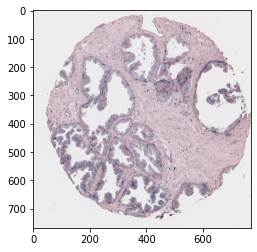

MASK
torch.Size([768, 768])
mask values:  tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


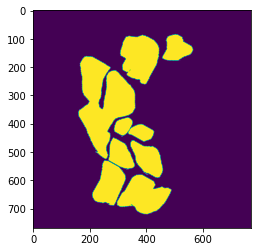

In [27]:
sample = train_dataset[0]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [28]:
loader_params = {'shuffle': True,
                 'num_workers': 18,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, batch_size = BATCH_SIZE, **loader_params)
loader_val = DataLoader(val_dataset, batch_size = 1, **loader_params)

In [47]:
for batch in loader_train:
    print(batch['image'].shape)
    break

torch.Size([2, 3, 768, 768])


# model training

## model

In [29]:
device = 'cuda:3'
DEVICE = device

In [30]:
from efficientunet import *

In [31]:
model = get_efficientunet_b5(out_channels=1,
                             concat_input=True, 
                             pretrained=True).to(device)

In [32]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

40321745

In [33]:
def lr_function(step):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 5e-4    #A
    rampup_epochs = 500; sustain_epochs = 200; exp_decay = .9999    #B
 
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:    #C
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:    #D
            lr = max_lr
        else:    #E
            lr = max((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs)* (0.8+0.3*np.sin(epoch / 100)), 0) + min_lr
        return lr
 
    return lr(step, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay) / max_lr

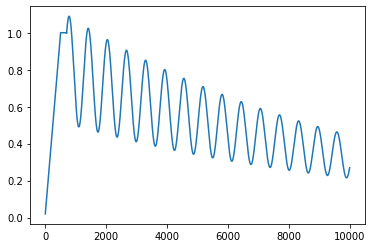

In [34]:
xxx = []
for i in range(10000):
    xxx.append(lr_function(i))
    
plt.plot(xxx)
plt.show()

In [35]:
def get_dice_coefficient(output, target):
    output,target = output.detach(),target.detach()
    assert output.size(0) == target.size(0)
    bs = output.size(0)
    output = F.logsigmoid(output).exp().view(bs,1,-1)
    output = output>0.5
    target = target.view(bs,1,-1)
    
    intersection = torch.sum(output*target,dim = (1,2))
    dice_coe = (2*intersection)/torch.sum(output+target,dim = (1,2))
    return dice_coe.mean()

In [36]:
bce_loss = nn.BCEWithLogitsLoss().to(device)

def dice_loss(pred_logits, target):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    
    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = torch.sigmoid(pred_logits).contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

def criterion(predicts,masks):
    return 0.5 * bce_loss(predicts, masks) + 0.5 * dice_loss(predicts, masks)

In [37]:
learning_rate = 0.001
# momentum = 0.9
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [38]:
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_function)

In [39]:
train_loss = []
accuracy = [] 
lr_hist = []

In [40]:
!mkdir checkpoint_fold_1

mkdir: cannot create directory ‘checkpoint_fold_1’: File exists


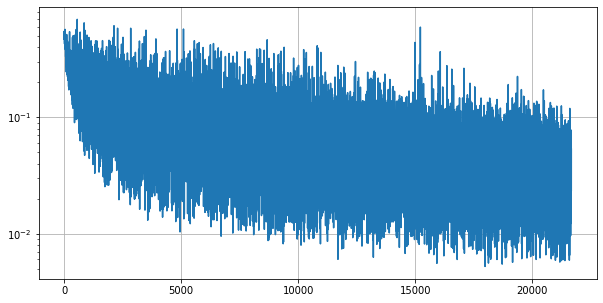

In [ ]:
N_EPOCHS = 200
for epoch in range(13, N_EPOCHS):
    model.train()
    
    batch_train_loss = []
    for iteration, batch in enumerate(loader_train, 1):
        
        images = batch['image'].to(device, dtype=torch.float)
        masks = batch['mask'].to(device, dtype=torch.float).unsqueeze(1)

        pred = model(images)
        loss = criterion(pred, masks)

        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                    
        if iteration % 10 == 0:
            print('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch + 1, iteration, len(loader_train), loss.item()))

        lr_hist.append(optimizer.param_groups[0]['lr'])
        scheduler_warmup.step()
            
        if iteration % 50 == 0:
            clear_output()

            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
        
    # val -------------------------------
    print('Eval')
    model.eval()
    
    mean_dice = 0
    mean_loss = 0
    mean_cnt = 0
  
    with torch.no_grad():
        for iteration, batch in tqdm(enumerate(loader_val, 1)):
            images = batch['image'].to(device, dtype=torch.float)
            masks = batch['mask'].to(device, dtype=torch.float).unsqueeze(1)

            pred = model(images)
            
            dice = get_dice_coefficient(pred, masks)
            
            loss = float(criterion(pred, masks).item())
            
            mean_dice += float(dice.item())
            
            mean_loss += loss
            
            mean_cnt += int(images.shape[0])
            
    mean_dice /= mean_cnt
    mean_loss /= mean_cnt
    print('EPOCH', epoch)
    print('Loss: ', mean_loss)
    print('Dice: ', mean_dice)
            
    torch.save(model.state_dict(), os.path.join(
        './checkpoint_fold_{}'.format(CURRENT_FOLD), 
        'effunet_ep_{:03d}_dice_{:08.6f}_loss_{:08.6f}.pt'.format(epoch, mean_dice, mean_loss)
    ))  

In [ ]:
2+2

In [50]:
33*160

5280